# **Step 0. Setup Environment**



In [8]:
# !pip install -qq praat-parselmouth
# !pip install -qq whisperx
# !pip install -qq stanza
!pip install -qq opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 29.0 MB/s eta 0:00:00


In [ ]:
!rm -r ../SpeechCARE_Explainability_Framework

In [ ]:
!git clone https://github.com/SpeechCARE/SpeechCARE_Explainability_Framework.git

In [5]:
import sys
sys.path.append('/SpeechCARE_Explainability_Framework')

In [6]:
%cd SpeechCARE_Explainability_Framework

/content/SpeechCARE_Explainability_Framework


In [21]:
# Model and weights management
from model.WeightsManager import WeightManager
from model.ModelWrapper import ModelWrapper

# SHAP analysis tools
from explainability.SHAP.AcousticShap import AcousticShap
from explainability.SHAP.LinguisticShap import LinguisticShap

from utils.Config import Config
from utils.Utils import load_yaml_file
from utils.dataset_utils import preprocess_data

# Pause extraction functionality
from acoustic_module.PauseExtraction import PauseExtraction
import acoustic_module


# Data processing and visualization
import pandas as pd
import yaml
import torch
from IPython.display import Image, display, Markdown, HTML
import os

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Initialize the weight manager
weight_manager = WeightManager()

try:
    # Download model checkpoint from Google Drive
    weight_path = weight_manager.download_weights(
        file_id="1-SLBGZRoNGRPHBtWJUDR8WCFpFiVYJM4",  # Google Drive file ID
        output_name="model.pt",                       # Name for downloaded file
    )
    print(f"Success: Weights saved to {weight_path}")

except Exception as e:
    print(f"Error downloading weights: {e}")
    print("Please check:")
    print("- Your internet connection")
    print("- The file ID is correct")
    print("- Google Drive permissions")

Downloading...
From (original): https://drive.google.com/uc?id=1-SLBGZRoNGRPHBtWJUDR8WCFpFiVYJM4
From (redirected): https://drive.google.com/uc?id=1-SLBGZRoNGRPHBtWJUDR8WCFpFiVYJM4&confirm=t&uuid=d6254b0f-1326-4cd0-9c8b-12da45ee98c8
To: /content/SpeechCARE_Explainability_Framework/model_weights/model.pt
100%|██████████| 1.62G/1.62G [00:20<00:00, 78.5MB/s]

Success: Weights saved to model_weights/model.pt


In [10]:
!mkdir model_weights
!cp -r ../model.pt model_weights/
weight_path = "model_weights/model.pt"

In [6]:
# !cp -r model_weights/model.pt ../

In [11]:
# Display model configuration
display(Markdown("### Model Configuration"))
with open("data/model_config.yaml") as f:
    model_config = yaml.safe_load(f)
    display(model_config)

# Display pause detection configuration
display(Markdown("### Pause Detection Configuration"))
with open("data/pause_config.yaml") as f:
    pause_config = yaml.safe_load(f)
    display(pause_config)

# Initialize config objects for the application
config = Config(load_yaml_file("data/model_config.yaml"))
config_pause = Config(load_yaml_file("data/pause_config.yaml"))

### Model Configuration

{'model_checkpoints': {'HUBERT': 'facebook/hubert-base-ls960',
  'WAV2VEC2': 'facebook/wav2vec2-base-960h',
  'mHuBERT': 'utter-project/mHuBERT-147',
  'MGTEBASE': 'Alibaba-NLP/gte-multilingual-base',
  'WHISPER': 'openai/whisper-large-v3-turbo'},
 'config': {'seed': 133,
  'bs': 4,
  'epochs': 14,
  'lr': '1e-6',
  'hidden_size': 128,
  'wd': '1e-3',
  'integration': 16,
  'num_labels': 3,
  'txt_transformer_chp': 'Alibaba-NLP/gte-multilingual-base',
  'speech_transformer_chp': 'utter-project/mHuBERT-147',
  'segment_size': 5,
  'active_layers': 12,
  'demography': 'age_bin',
  'demography_hidden_size': 128,
  'max_num_segments': 7}}

### Pause Detection Configuration

{'config': {'device': 'cpu',
  'batch_size': 16,
  'compute_type': 'int8',
  'model_id': 'large-v3'}}

## **Step 1: Model Initialization & Data Preprocessing**
---

### **Model Intialization:**
The SpeechCARE model with trained checkpoint is loaded here.


**Key Components:**

- `ModelWrapper`: Handles model architecture

- `config`: Contains model parameters

- `weight_path`: Location of trained SpeechCARE model checkpoint

In [ ]:
# Initialize model wrapper with configuration
wrapper = ModelWrapper(config)

# Load trained weights into the model
model = wrapper.get_model(weight_path)
model.eval()

print("Model successfully initialized with weights from:", weight_path)

### **Data Preprocessing:**

Prepares a specific audio sample by denoising the audio, providing its transcription and age category. You should provide:

- `AUDIO_PATH`: Full path to the audio file, WAV format recommended (required for an individual sample) .
- `AGE`: Age of the speaker as an integer value (required for an individual sample).

In [13]:
AUDIO_PATH = f"../qnvo.mp3"  # Path to the input audio file (update it with your desired audio file path)
AGE = 72  # Age of the speaker

In [ ]:
# Process audio sample and corresponding age
# Arguments:
#   audio_path: Path to input audio file
#   age: Speaker's age
#   output_dir: Directory to store processed audio file

processed_audio_path, demography_info, transcription = preprocess_data(audio_path=AUDIO_PATH, age=AGE, output_dir='../processed_audio')

# Convert age (by default: int) to tensor
# Reshaped it to (1, 1) for batch processing compatibility
demography_tensor = torch.tensor(demography_info, dtype=torch.float16).reshape(1, 1)

# --- Word-Level Analysis Setup ---
# Print analysis information for verification
print(f"Analyzing sample: {processed_audio_path}")
print(f"Speaker age category: {demography_info}")


# **Acoustic Module: Spectrogram Visualization & Acoustic Feature Analysis**
---
Visualizing SHAP augmented spectrogram; plotting Fundamental Frequency [F0] & Third Formant Frequency [F3] on the spectrogram; plotting pauses on the spectrogram; plotting rhythmic structure; computing Shimmer & Energy of Frequency Domain.

In [15]:
# Initalize the acoustic explainer class for model interpretation
acoustic_explainer = AcousticShap(model)
print("Acoustic explainer ready for analysis")

Acoustic explainer ready for analysis


## **Original Spectrogram Visualization**

Generates and displays the original log-mel spectrogram of the sample.



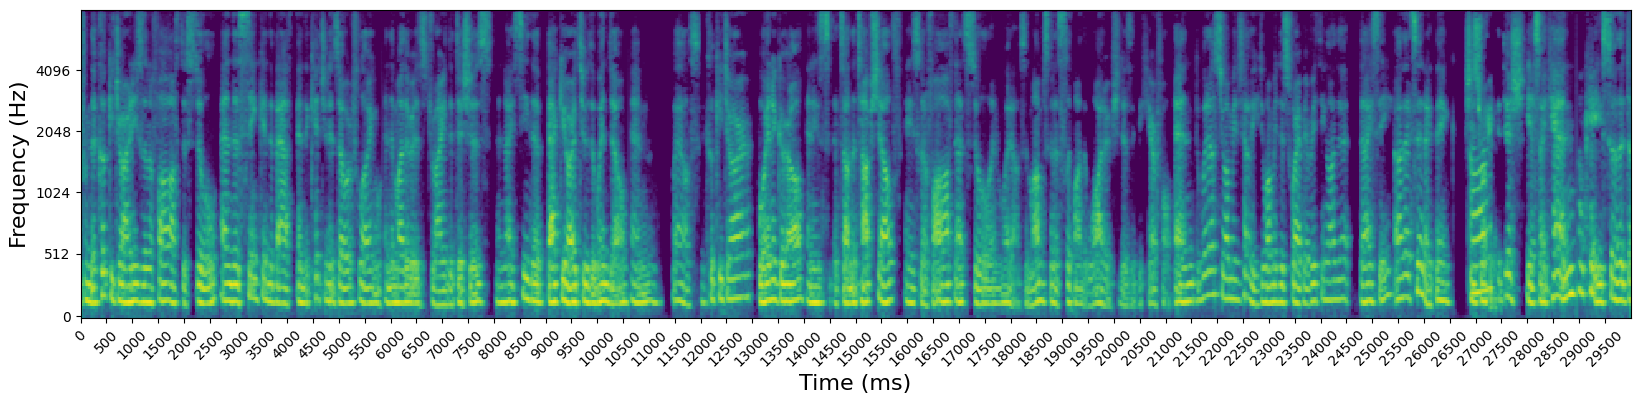

In [16]:
# Create and display original spectrogram
original_spectrogram = acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    sr=16000,
    spectrogram_type="original",
    pauses=None,  # Can add pause markers if available
    plot=True  # Set to False to suppress display
)

## **SHAP-Augmented Spectrogram Visualization**

* SHAP Analysis: SHAP was used to assess the impact of each specified segment on predictions by applying masking and computing SHAP values.

* Spectrogram Visualization: SHAP values were mapped onto Log-Mel spectrograms, with segment opacity adjusted to highlight informative vocal cues.

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the
Preprocessing audio...
Tokenizing transcription...
Running inference...


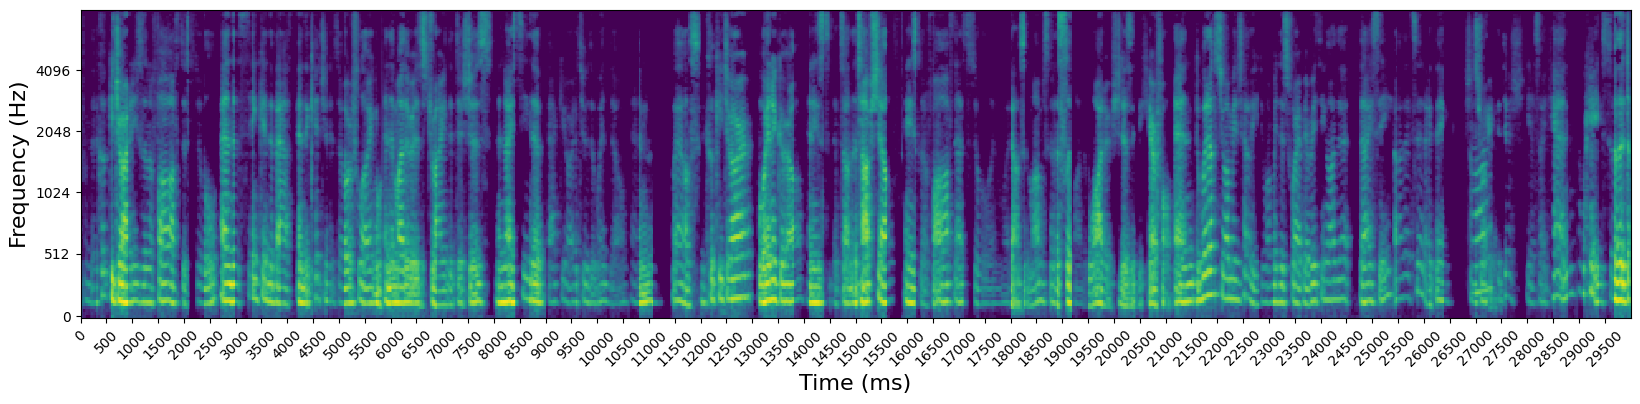

In [17]:
# Generate and visualize the SHAP spectrogram
SHAP_spectrogram = acoustic_explainer.get_speech_spectrogram(processed_audio_path, demography_tensor, config,sr=16000,
                                                             spectrogram_type = 'shap', plot=True)

## **Computing & Visualization of Key Acoustic Features**

- Visualizing Fundamental Frequency (F0) & Third Formant Frequency (F3) on the spectrogram
- Visualizing the speaker's rhythmic structure by computing Shannon Entropy. Less rhythmic/monotonous segments, identified by lower fluctuations, are highlighted in red.



Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the
Preprocessing audio...
Tokenizing transcription...
Running inference...


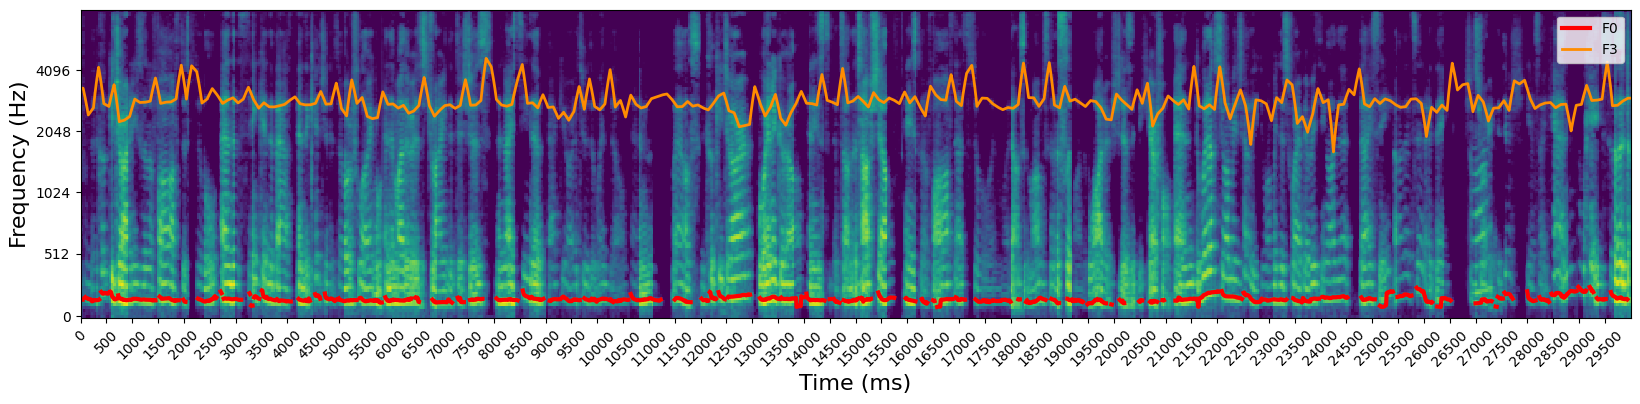

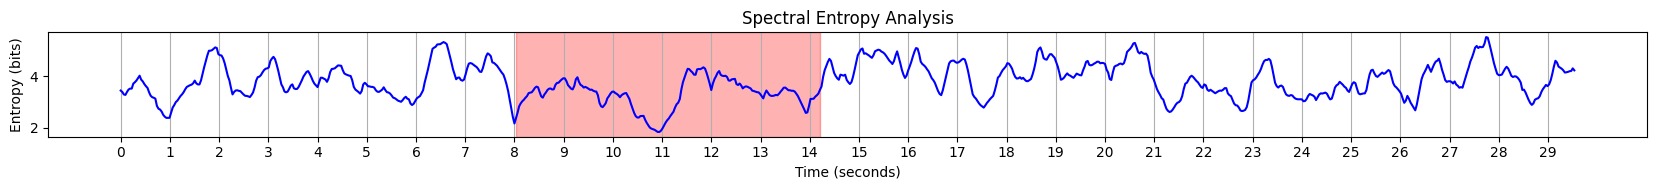

Detected flat segments (start, end in seconds):
8.03 - 14.21


In [18]:
# Generate SHAP spectrogram with formants and entropy analysis
SHAP_spectrogram, shannon_entropy, flat_segments, formats = acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    sr=16000,
    spectrogram_type='shap',
    formants_to_plot=["F0", "F3"],  # Show fundamental and third formant
    include_entropy=True,  # Add spectral entropy plot
    plot=True,
    entropy_kwargs={
        'window_size': 15,
        'min_duration': 5,
        'segments_std_threshold':.4,
        'segments_merge_gap':.5,
        'dpi':100,
        'figsize':(16.67,2)
    }
)


## **Pause Analysis & Visualization**

- Detect pauses
- Identify informative pauses (pauses before nouns) by analyzing the part-of-speech (POS) tags of surrounding words. In this report, we have improved our previous method by additionally marking pauses near conjunctions and uncertainty words as they are informative.
- Highlight the pauses on the spectrogram


**Key Parameters:**

- `energy_threshold`: Lower values detect more subtle pauses

- `min_pause_duration`: Adjust to ignore very short pauses

- `expansion_threshold`: Boundary expansion threshold for refining pauses
- `marked=True`: Highlights linguistically informative pauses

- `refined=True`: Extra refinement to make pauses more accurate


In [19]:
# Configure pause detection parameters
energy_threshold = 0.001  # RMS threshold for silence
sr = 48000  # Audio sample rate
min_pause_duration = 0.1  # Minimum pause length in seconds
expansion_threshold = 0.03  # Boundary expansion threshold

# Initialize pause extractor
pause_extractor = PauseExtraction(config_pause, processed_audio_path)

# Extract and mark significant pauses
pauses = pause_extractor.extract_pauses(
    sr=sr,
    energy_threshold=energy_threshold,
    min_pause_duration=min_pause_duration,
    expansion_threshold=expansion_threshold,
    marked=True,  # Mark important pauses
    refined=True  # Use refined boundaries
)

print(f"Detected {len(pauses)} pauses in audio sample")

DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _speechbrain_save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _speechbrain_load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for load
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint save hook for _save
DEBUG:speechbrain.utils.checkpoints:Registered checkpoint load hook for _recover
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/2.39k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

model.bin:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

vocabulary.json:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

No language specified, language will be first be detected for each audio file (increases inference time).
>>Performing voice activity detection using Pyannote...


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../usr/local/lib/python3.11/dist-packages/whisperx/assets/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.2. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.6.0+cu124. Bad things might happen unless you revert torch to 1.x.
Detected language: en (1.00) in first 30s of audio...


Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth
100%|██████████| 360M/360M [00:01<00:00, 247MB/s]


Detected 2 pauses in audio sample


Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the
Preprocessing audio...
Tokenizing transcription...
Running inference...


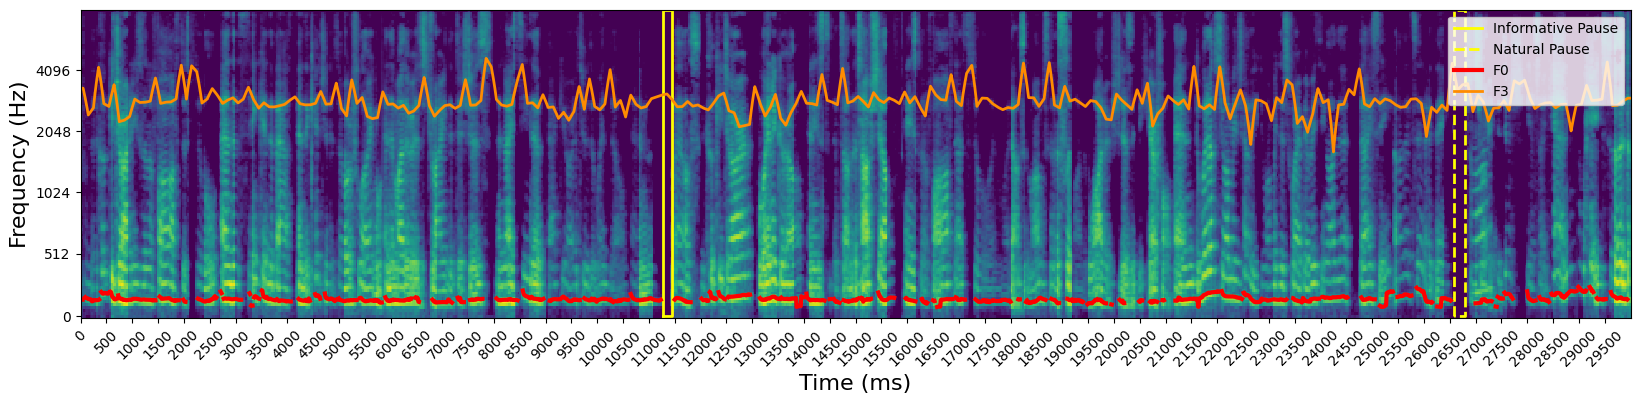

In [20]:
# Visualize with marked pauses
SHAP_spectrogram , formats = acoustic_explainer.get_speech_spectrogram(
    audio_path=processed_audio_path,
    demography_info=demography_tensor,
    config=config,
    spectrogram_type='shap',
    pauses=pauses,  # Pass detected pauses
    formants_to_plot=["F0", "F3"],
    include_entropy=False,
    plot=True
)

## **Acoustic Feature Analysis with Quartile Categorization**

This analysis compares the given audio sample against reference distributions of key acoustic features (Shimmer standard deviation, energy of frequency domain, Fundamental Frequency [F0] standard deviation, and Third Formant Frequency [F3] standard deviation) in the reference dataset.

**Reference Dataset Specifications**

> The reference dataset provides values for key acoustic features, computed from all audio recordings of the "Picture Description" task (N = 1,168 samples), which was saved in `data/vocal_features.csv`. These values support quantitative comparisons of individual recordings' key acoustic features against cohort-level distributions derived from the PREPARE challenge training data. For each feature, the range of values is divided into quartiles (Q1-Q4).


**Using Custom Datasets (Datasets other than the PREPARE challenge dataset, ignore this information if you don't have a custom dataset)**
> Please note that if you intend to use a different dataset instead of the PREPARE challenge dataset and create a new reference dataset, you must provide the path to a folder where the audio files are stored. This folder should contain a large number of audio files (e.g., equivalent to the size of the Picture Description task dataset used in the challenge [N = 1168]). These audio files will be used to calculate the distribution of key acoustic features and to determine their corresponding quartiles, which will be used for the interpretation of the acoustic features as described below.

### **Feature Categorization**

This section provides definitions for key acoustic features. You can skip the following descriptions if you are familiar with these features.

**1. Shimmer Standard Deviation**:

  Shimmer represents voice stability by analyzing amplitude variation.

  - Shimmer standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Stable, Almost Stable, Almost Unstable, Unstable). These categories are determined by computing quartiles of shimmer standard deviation uisng the reference dataset.

**2. Energy of Frequency Domain**:

  Energy of frequency domain quantifies vocal power spectral density.

  - Energy in frequency domain is calculated for the given audio sample and mapped to the corresponding caregories (Very Low, Low, Moderate, High). These categories are determined by computing quartiles of energy of frequency domain using the reference dataset.

**3. Fundamental Frequency (F0) Standard Deviation**

  Fundamental frequency (F0) is the lowest frequency of a periodic waveform and determines the pitch of a sound.


  - F0 standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Very Flat, Slightly Flat, Natural, Dynamic). These categories are determined by computing quartiles of F0 standard deviation using the reference dataset.


**4. Third Formant Frequency (F3) Standard Deviation**

  F3 is the third resonance frequency shaped by fine tongue-tip and lip coordination.

  - F3 standard deviation is calculated for the given audio sample and mapped to the corresponding caregories (Very Limited Coordination, Limited Coordination, Normal Coordination, High Coordination). These categories are determined by computing quartiles of F3 standard deviation using the reference dataset.


**Key Parameters:**

- `data_df`: Reference Dataset containing the computed acoustic features

- `audio_path`: the sample audio path (MP3/WAV)

- `feature_column`: Which feature to analyse (`['shimmer_std','energy_frequency_domain', 'fundamental_frequency','formant_frequency']`)

In [23]:
# Load key acoustic features from CSV of the reference dataset
REFERENCE_DATASET_DIR = None # Leave this unchange if you don't have a custom dataset, otherwise, put the path to your audio data folder
if REFERENCE_DATASET_DIR:
    data_df = acoustic_module.FeatureExtraction.get_audio_files(REFERENCE_DATASET_DIR , 1168)
else:
    data_df = pd.read_csv("data/vocal_features.csv")

### **Shimmer Standard Deviation Analysis**

In [24]:
# Analyze and categorize Shimmer standard deviation of an individual audio sample
# Compares against reference distribution in data_df
shimmer_info = acoustic_module.FeatureExtraction.analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'shimmer_std'                 # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'shimmer_std' were calculated based on this reference distribution.

Analysis Results for qnvo:
- shimmer_std value: 0.7331
- Quartile category: Q3: Almost Unstable

Full Quartile Ranges:
  Q1: Stable          : 0.3054 to 0.5041
  Q2: Almost Stable   : 0.5041 to 0.7028
  Q3: Almost Unstable : 0.7028 to 0.9015
  Q4: Unstable        : 0.9015 to 1.1002


### **Energy Frequency Domain Analysis**

In [25]:
# Analyze and categorize energy of frequency domain
# Compares against reference distribution in data_df
energy_info = acoustic_module.FeatureExtraction.analyze_column_single(
    data_df,                      # Reference feature dataset
    AUDIO_PATH,                   # Individual audio sample path
    'energy_frequency_domain'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'energy_frequency_domain' were calculated based on this reference distribution.

Analysis Results for qnvo:
- energy_frequency_domain value: 96.9050
- Quartile category: Q4: High

Full Quartile Ranges:
  Q1: Very Low        : 49.3604 to 64.2618
  Q2: Low             : 64.2618 to 79.1631
  Q3: Moderate        : 79.1631 to 94.0644
  Q4: High            : 94.0644 to 108.9657


### **Fundamental Frequency (F0) Standard Deviation Analysis**

In [26]:
# Analyze and categorize F0 standard deviation distribution
# Compares against reference distribution in data_df
fundamental_frequency_info = acoustic_module.FeatureExtraction.analyze_column_single(
    data_df,                   # Reference feature dataset
    AUDIO_PATH,                # Individual audio sample path
    'fundamental_frequency'    # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'fundamental_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- fundamental_frequency value: 0.2414
- Quartile category: Q2: Slightly Flat

Full Quartile Ranges:
  Q1: Very Flat       : 0.0317 to 0.1586
  Q2: Slightly Flat   : 0.1586 to 0.2855
  Q3: Natural         : 0.2855 to 0.4124
  Q4: Dynamic         : 0.4124 to 0.5393


### **Third Formant Frequency (F3) Analysis**

In [27]:
# Analyze and categorize F3 standard deviation distribution
# Compares against reference distribution in data_df
formant_frequency_info = acoustic_module.FeatureExtraction.analyze_column_single(
    data_df,                # Reference feature dataset
    AUDIO_PATH,             # Individual audio sample path
    'formant_frequency'     # Feature to analyze
)

Reference Data Information:
- Total samples used for quartile calculation: 1,168

The quartile ranges for 'formant_frequency' were calculated based on this reference distribution.

Analysis Results for qnvo:
- formant_frequency value: 0.0992
- Quartile category: Q2: Limited Coordination

Full Quartile Ranges:
  Q1: Very Limited Coordination: 0.0407 to 0.0828
  Q2: Limited Coordination: 0.0828 to 0.1249
  Q3: Normal Coordination: 0.1249 to 0.1670
  Q4: High Coordination: 0.1670 to 0.2091


# **Linguistic Module: SHAP-Highlighted Transcripts**


---
Visualization of linguistic cues using SHAP (Shapley Additive exPlanations). This process generates SHAP values, quantifying the contribution of each textual input's token to the SPeechCARE model decision making.





#### Initalizing the linguisticc explainer class


In [28]:
linguistc_explainer = LinguisticShap(model)
print("Linguistic explainer ready for analysis")

Linguistic explainer ready for analysis


#### Run inference to get predicted_label and transcription

In [29]:
model.inference(processed_audio_path, demography_tensor, config)
print("Running inference to compute predicted_label and transcription.")

Transcribing audio...
Transcription:  from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the
Preprocessing audio...
Tokenizing transcription...
Running inference...
Running inference to compute predicted_label and transcription.


#### Generating SHAP values

In [30]:
shap_values, html_result = linguistc_explainer.get_text_shap_results()

Running SHAP values...
Input text: [" from the cookie jar and he's going to fall off the stool and the sink and the bath and the kitchen is overflowing and the mother is drying the dishes and I see the backyard through the window and what else? The cookie jar, boy and a girl and it's on the top shelf and he's going to fall off that stool and what else? The mom's going to slip on the water if she doesn't be careful. And what else do you want me to tell you? Do you want me to describe everything on that that I see? Oh, that's it, I think. She's drying the dish. Yes, I can. Okay, so the"]


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.23s/it]               

Values explained...
In len 2
mci


#### Highlighting informative linguistic cues

In [31]:
display(HTML(html_result))